In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys, os, subprocess
import argparse
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='w|arn'
import seaborn as sns
# from pathlib import Path
# path = str(Path(Path(__file__).parent.absolute()).parent.absolute())
# sys.path.insert(0, path)
# from libraries.functions import *
# from libraries.particles import *
from scipy.interpolate import griddata
import math
from scipy.signal import savgol_filter



In [2]:
def create_grid_velocities_crust (xmin_plot:float, xmax_plot:float, ymin_plot:float, ymax_plot:float, grid_res:float, grid_low_res:float, grid_high_res: float)  :
    # create grid to interpolate stuff onto (for plotting)
    x_low = np.linspace(xmin_plot,xmax_plot,int((xmax_plot-xmin_plot)/grid_res))
    y_low =  np.linspace(ymin_plot,ymax_plot,int((ymax_plot-ymin_plot)/grid_res))
    X_low, Y_low = np.meshgrid(x_low,y_low)
    # lower res grid for velocities
    x_vels = np.linspace(xmin_plot,xmax_plot,int((xmax_plot-xmin_plot)/grid_low_res))
    y_vels =  np.linspace(ymin_plot,ymax_plot,int((ymax_plot-ymin_plot)/grid_low_res))
    X_vels, Y_vels = np.meshgrid(x_vels,y_vels)
    # higher res grid for crust
    x_crust = np.linspace(xmin_plot,xmax_plot,int((xmax_plot-xmin_plot)/grid_high_res))
    y_crust =  np.linspace(ymin_plot,ymax_plot,int((ymax_plot-ymin_plot)/grid_high_res))
    X_crust, Y_crust = np.meshgrid(x_crust,y_crust)
    return (X_low, Y_low, X_vels, Y_vels, X_crust, Y_crust)


def interp_T_visc_vx_vz_compCrust (x, y, T, visc, vx, vz, C, X_low, Y_low, X_vels, Y_vels, X_crust, Y_crust):
    Temp = griddata((x, y), T-273,    (X_low, Y_low), method='cubic')
    Visc = griddata((x, y), visc, (X_low, Y_low), method='line_mid_mid_mid_midar') 
    Vx = griddata((x, y), vx,   (X_crust, Y_crust), method='cubic')
    Vz = griddata((x, y), vz,   (X_crust, Y_crust), method='cubic')
    Comp = griddata((x, y), C,   (X_crust, Y_crust), method='cubic')
    return (Temp, Visc, Vx, Vz, Comp)


def interp_vmag_comp (x, y, v, C, X_crust, Y_crust):
    V = griddata((x, y), v,   (X_crust, Y_crust), method='cubic')
    Comp = griddata((x, y), C,   (X_crust, Y_crust), method='cubic')
    return (V, Comp)

def get_points_with_y_in(data, depth, delta, ymax = 2900.e3): 
    plate_prof_loc = ymax - depth
    within_delta_from_depth = (data['Points:1'] < plate_prof_loc + delta) &(data['Points:1'] > plate_prof_loc - delta)
    return data[within_delta_from_depth].sort_values('Points:0').copy(True)

def get_trench_position(p, threshold = 0.3e7):
    if "oc" in p.columns:
        tr =  p.loc[(p['Points:0']> threshold) & (p['oc'] > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    elif {"oc","sed"}.issubset(p.columns):
        sumcomp = p["oc"] + p["sed"]
        tr =  p.loc[(p['Points:0']> threshold) & (sumcomp > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    else:
        sumcomp = p["oc"] + p["serp"]
        tr =  p.loc[(p['Points:0']> threshold) & (sumcomp > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    return tr

def get_crust(contour):    
    conts = len(contour.collections[0].get_paths())
    j = 0
    # for i in range(conts):
    #     if len(contour.collections[0].get_paths()[j]) < len(contour.collections[0].get_paths()[i]):
    #         j = i
    pts = contour.collections[0].get_paths()[j].vertices
    return pts

In [3]:
csvs_loc =  '/home/vturino/PhD/projects/exhumation/gz_outputs/'
models_loc =  '/home/vturino/PhD/projects/exhumation/raw_outputs/'
json_loc = '/home/vturino/PhD/projects/exhumation/pyInput/'

json_file = 'kin19_shear100.json'
with open(f"{json_loc}{json_file}") as json_file:
        configs = json.load(json_file)
        setting = 'none'

m = configs['models'][0]

In [4]:
t = 30

data = pd.read_parquet(f"{csvs_loc}{m}/fields/full.{t}.gzip") 
pts = get_points_with_y_in(data, 20.e3, 2.e3, ymax = 900.e3)
trench= get_trench_position(pts,threshold = 0.13e7)
xmin_plot = 0.e3
xmax_plot = 5400.e3
ymin_plot = 0.e3
ymax_plot = 900.e3

data["vel"] = np.sqrt(data["velocity:0"]**2 + data["velocity:0"]**2)
data["comp"] = data["sed"]+data["oc"]

In [5]:
trench


2396090.0

In [6]:
grid_res=5.e3; grid_low_res = 20.e3; grid_high_res = 0.5e3
X_low, Y_low, X_vels, Y_vels, X_crust, Y_crust = create_grid_velocities_crust (xmin_plot, xmax_plot, ymin_plot, ymax_plot, grid_res, grid_low_res, grid_high_res)
vel, comp = interp_vmag_comp(data.loc[:,'Points:0'], data.loc[:,'Points:1'], data.loc[:,"vel"], data.loc[:,'comp'], X_crust, Y_crust)     



(-120.0, 0.0)

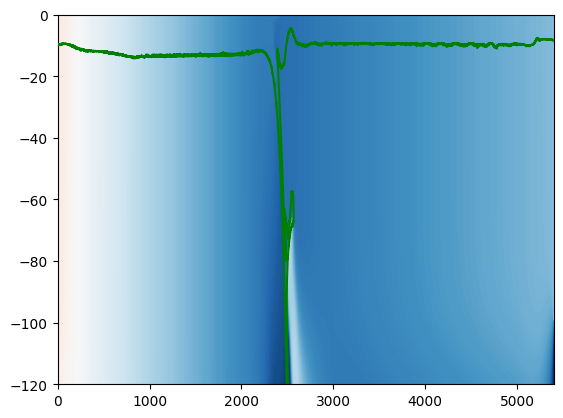

In [7]:
v_plot = plt.contourf(X_crust/1.e3, -(ymax_plot-Y_crust)/1.e3, vel,cmap=matplotlib.colormaps.get_cmap('RdBu_r'),levels=np.linspace(0,0.06,301),extend='both')
crust_cont = plt.contour(X_crust/1.e3, -(ymax_plot-Y_crust)/1.e3, comp, levels=[0.3], linewidths=2, colors='yellow', zorder=2, alpha = 0)
crust_vec = get_crust(crust_cont)

crust=pd.DataFrame(columns=['X', 'Y'])
crust['X'] = crust_vec[:,0]
crust['Y'] = crust_vec[:,1]


plt.plot(crust.X, crust.Y, c= "green", zorder = 10)
plt.ylim(-120,0)
# plt.xlim(xmin_plot/1.e3, xmax_plot/1.e3)
# plt.gca().set_aspect('equal', adjustable='box')



In [76]:
fil_m = ((crust["Y"]<=-49) & (crust["Y"]>=-51))
mid = crust[fil_m].min()
max_mid = crust[fil_m].max()
# print(mid, max_mid)

fil_t = ((crust["Y"]<=-29) & (crust["Y"]>=-31))
top = crust[fil_t].min()
max_top = crust[fil_t].max()

fil_b = ((crust["Y"]<=-69.8) & (crust["Y"]>=-70.2))
bot = crust[fil_b].min()
max_bot = crust[fil_b].nsmallest(5, columns="X").iloc[-2]
print(bot, max_bot)

X    2449.22678
Y     -70.08995
dtype: float64 X    2471.981351
Y     -70.038911
Name: 8923, dtype: float64


(2400.0, 2600.0)

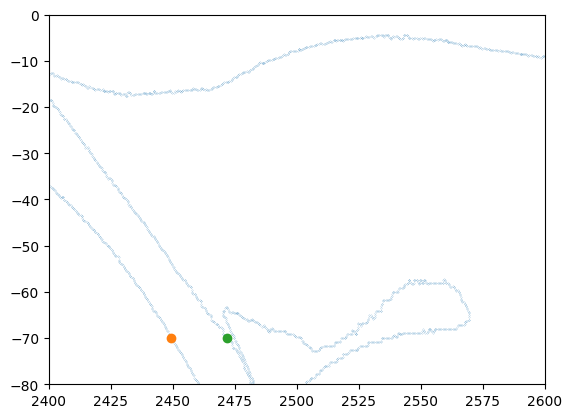

In [77]:
plt.scatter(crust.X, crust.Y, s = 0.01)
plt.scatter(bot.X, bot.Y)
plt.scatter(max_bot.X, max_bot.Y)
plt.ylim(-80,0)
plt.xlim(2400,2600)

In [38]:
h = abs(bot["Y"] - top["Y"])
l = np.sqrt((bot["Y"] - top["Y"])**2 + (bot["X"] - top["X"])**2)

dip = np.arcsin(h/l)
alpha = (np.pi/2 - dip)
dmid = (max_mid.X-mid.X)*(np.cos(alpha))
dtop = (max_top.X-top.X)*(np.cos(alpha))
dbot = (max_bot.X-bot.X)*(np.cos(alpha))
sl = np.tan(alpha)


line_mid= pd.DataFrame(columns=["X", "Y"])
line_mid.X = np.array(range(int(trench/1.e3 - 50),int(trench/1.e3 + 150)))
line_mid.Y = sl*(line_mid.X-mid.X) +mid.Y
line_mid = line_mid[((line_mid.X >= mid.X) & (line_mid.X <= mid.X + dtop*np.cos(alpha)))]



line_top= pd.DataFrame(columns=["X", "Y"])
line_top.X = np.array(range(int(trench/1.e3 - 50),int(trench/1.e3 + 150)))
line_top.Y = sl*(line_top.X-top.X) +top.Y
line_top = line_top[((line_top.X >= top.X) & (line_top.X <= top.X + dtop*np.cos(alpha)))]


line_bot= pd.DataFrame(columns=["X", "Y"])
line_bot.X = np.array(range(int(trench/1.e3 - 50),int(trench/1.e3 + 150)))
line_bot.Y = sl*(line_bot.X-bot.X) +bot.Y
line_bot = line_bot[((line_bot.X >= bot.X) & (line_bot.X <= bot.X + dbot*np.cos(alpha)))]



In [39]:
trench

2396090.0

In [40]:
data_c=data[data["oc"]+data["sed"]>0]
v_mid = griddata((data_c.loc[:,'Points:0']/1.e3, -(ymax_plot - data_c.loc[:,'Points:1'])/1.e3), data_c.vel, (line_mid.X, line_mid.Y), method="cubic")
v_top = griddata((data_c.loc[:,'Points:0']/1.e3, -(ymax_plot - data_c.loc[:,'Points:1'])/1.e3), data_c.vel, (line_top.X, line_top.Y), method="cubic")
v_bot = griddata((data_c.loc[:,'Points:0']/1.e3, -(ymax_plot - data_c.loc[:,'Points:1'])/1.e3), data_c.vel, (line_bot.X, line_bot.Y), method="cubic")

In [41]:
line_mid["vel"] = v_mid
line_mid = line_mid.dropna()
line_mid["yn"]=(line_mid.Y - line_mid.Y.min())/abs(line_mid.Y.max()-line_mid.Y.min())

line_top["vel"] = v_top
line_top = line_top.dropna()
line_top["yn"]=(line_top.Y - line_top.Y.min())/abs(line_top.Y.max()-line_top.Y.min())

line_bot["vel"] = v_bot
line_bot = line_bot.dropna()
line_bot["yn"]=(line_bot.Y - line_bot.Y.min())/abs(line_bot.Y.max()-line_bot.Y.min())


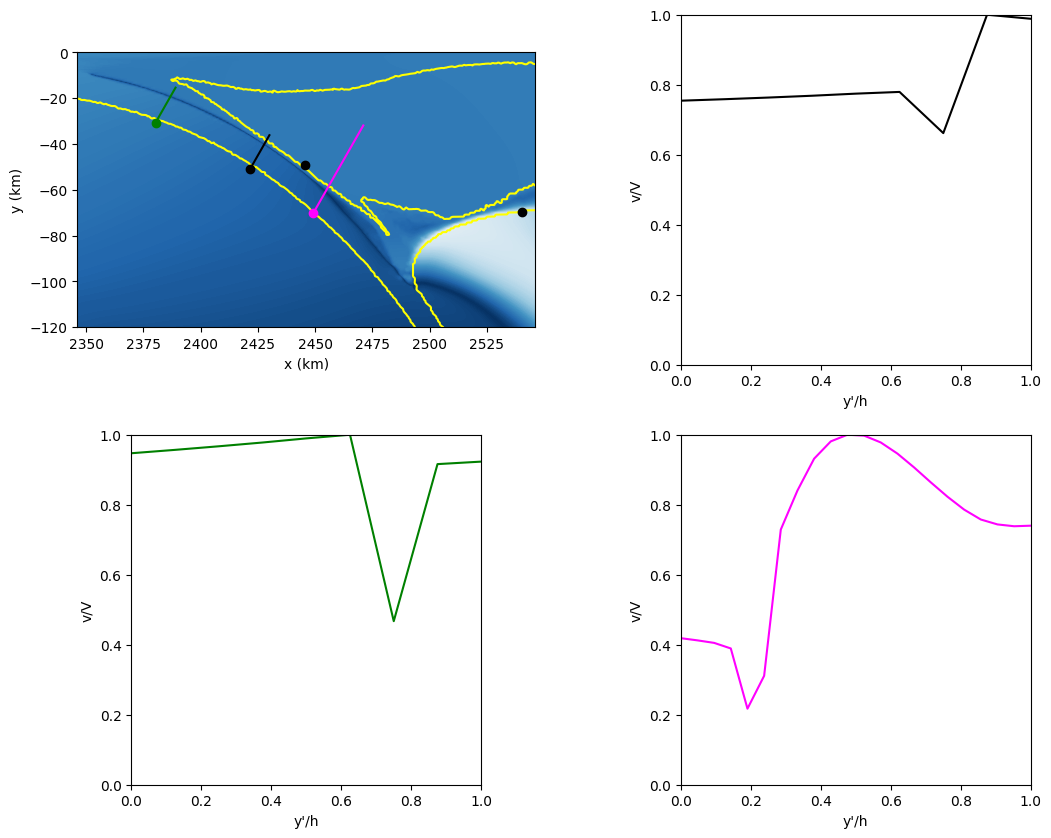

In [42]:
fig, ax = plt.subplots(2,2, figsize = (13,10))

v_plot = ax[0,0].contourf(X_crust/1.e3, -(ymax_plot-Y_crust)/1.e3, vel,cmap=matplotlib.colormaps.get_cmap('RdBu_r'),levels=np.linspace(0,0.05,301),extend='both')
ax[0,0].scatter(mid.X, mid.Y, c= "black", zorder = 10)
ax[0,0].scatter(max_mid.X, max_mid.Y, c= "black", zorder = 10)
ax[0,0].scatter(top.X, top.Y, c= "green", zorder = 10)
ax[0,0].scatter(bot.X, bot.Y, c= "magenta", zorder = 10)
ax[0,0].scatter(max_bot.X, max_bot.Y, c= "black", zorder = 10)
ax[0,0].plot(crust.X, crust.Y, c= "yellow", zorder = 1)
ax[0,0].plot(line_mid.X, line_mid.Y, c = "black")
ax[0,0].plot(line_top.X, line_top.Y, c = "green")
ax[0,0].plot(line_bot.X, line_bot.Y, c = "magenta")
ax[0,0].set_ylim(-120,0)
ax[0,0].set_xlim(trench/1.e3 - 50, trench/1.e3+150)
ax[0,0].set_xlabel("x (km)")
ax[0,0].set_ylabel("y (km)")
ax[0,0].set_aspect('equal', adjustable='box')

ax[0,1].plot(line_mid.yn,line_mid.vel/line_mid.vel.max(), c="black")
ax[0,1].set_xlabel("y'/h")
ax[0,1].set_ylabel("v/V")
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)
ax[0,1].set_aspect('equal', adjustable='box')

ax[1,0].plot(line_top.yn,line_top.vel/line_top.vel.max(), c="green")
ax[1,0].set_xlabel("y'/h")
ax[1,0].set_ylabel("v/V")
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_aspect('equal', adjustable='box')

ax[1,1].plot(line_bot.yn,line_bot.vel/line_bot.vel.max(), c="magenta")
ax[1,1].set_xlabel("y'/h")
ax[1,1].set_ylabel("v/V")
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)
ax[1,1].set_aspect('equal', adjustable='box')